### Описание и цель проекта

Проект направлен на исследование данных из открытых источников, несущих информацию о продажах игр для разных приставок по годам, распределение их по регионам, а так же информацию об оценках критиков и пользователей. Дополнительно представлена информация по рейтингу  ESRB.

Цель исследования выявить закономерности, определяющие успешность игр.

В ходе работы предстоит провести подготовку данных, их обработку, исследовательский анализ и проверку двух гипотез. 

### 0. Импорт необходимых библиотек

In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from scipy import stats as st

### 1. Получение данных и первичной информации о них

In [107]:
# Файла данных
data = pd.read_csv('datasets/games.csv')

data.info()  # Общая информация
display(data.head())  # Смотрим что есть.
display(data['Rating'].unique())  # Не знаю что может быть, поэтому смотрю какие всрианты возможны

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

В датасете 16715 строк записей. Данные разных типов. Присутствуют пропуски данных, некоторые данные представлены NaN.

### 2. Предобработка данных

#### 2.1 Замена названий столбцов

In [108]:
#  Переименовываем названия столбцов привoдя к нижнему регистру.
# renames = {'Name': 'name', 'Platform': 'platform', ...}; data = data.rename(columns = renames)
data.columns = data.columns.str.lower()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


#### 2.2 Преобразование типов данных

Преобразуем колонку "год выпуска"  к целому числу, а колонку с оценкой пользователей к вещественному, так как в ней наблюдаются дробные значения.

In [109]:
# Год в целое

display(data['year_of_release'].unique())    # Посмотреть какие года есть
data['year_of_release'] = data['year_of_release'].fillna(0)
data['year_of_release'] = data['year_of_release'].astype('int')

# Оценка пользователей в float
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')    # В случае NaN -  пропускаем и оставляем.

display(data.info())

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16715 non-null  int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       7590 non-null   float64
 10  rating           9949 non-null   object 
dtypes: float64(6), int64(1), object(4)
memory usage: 1.4+ MB


None

#### 2.3 Обработка пропусков

In [110]:
# Все пропуски по столбцам:
display(data.isna().sum())

for pos in ('name', 'genre'):
    display(data[pos].unique())

name                  2
platform              0
year_of_release       0
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

array(['Wii Sports', 'Super Mario Bros.', 'Mario Kart Wii', ...,
       'Woody Woodpecker in Crazy Castle 5', 'LMA Manager 2007',
       'Haitaka no Psychedelica'], shape=(11560,), dtype=object)

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

По два пропуска в столбцах 'name' и 'genre', большАя часть в столбцах с оценками и рейтингами.

In [111]:
# Детально посмотрим что за пропуски в названиях и жанрах

for pos in ('name', 'genre'):
    display(data[pos].unique())

    missing_values = data[pos].isnull().sum()
    print(f"Количество пропусков в {pos}: {missing_values}")
    nan_indices = data[data[pos].isnull()].index
    print(f"Индексы пропусков в {pos}: {list(nan_indices)}")
display(data.loc[[659, 14244]])

array(['Wii Sports', 'Super Mario Bros.', 'Mario Kart Wii', ...,
       'Woody Woodpecker in Crazy Castle 5', 'LMA Manager 2007',
       'Haitaka no Psychedelica'], shape=(11560,), dtype=object)

Количество пропусков в name: 2
Индексы пропусков в name: [659, 14244]


array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy', nan], dtype=object)

Количество пропусков в genre: 2
Индексы пропусков в genre: [659, 14244]


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Две игры. Не оценивались и не имеют рейтинга. Продажи низкие. Предварительное решение - удаляем.

In [112]:
# Удаляем строки по индексам

data = data.drop(nan_indices).reset_index(drop=True)

Посмотрим в каких случаях проявляются значения NaN.

In [113]:
print(data.query('critic_score.isna()').head(10))
# print(data.query('critic_score.isna() and user_score.isna() and rating.isna()').count())

                             name platform  year_of_release         genre  \
1               Super Mario Bros.      NES             1985      Platform   
4        Pokemon Red/Pokemon Blue       GB             1996  Role-Playing   
5                          Tetris       GB             1989        Puzzle   
9                       Duck Hunt      NES             1984       Shooter   
10                     Nintendogs       DS             2005    Simulation   
12    Pokemon Gold/Pokemon Silver       GB             1999  Role-Playing   
18              Super Mario World     SNES             1990      Platform   
20  Pokemon Diamond/Pokemon Pearl       DS             2006  Role-Playing   
21               Super Mario Land       GB             1989      Platform   
22            Super Mario Bros. 3      NES             1988      Platform   

    na_sales  eu_sales  jp_sales  other_sales  critic_score  user_score rating  
1      29.08      3.58      6.81         0.77           NaN         NaN

NaN появляется во все года, во всех платформах и жанрах, по самым разным продажам. Закономерности не видно, поэтому заменить чем-то конкретным трудно. Оставляем как есть. 

<b>'tbd'</b> -  to be determined - значения должны быть определены. Но пока это строковое значение, по каким-то причинам. Возможно пользователям не предлагалось оценить игру. Так как оценка <b>пока</b> не определена, заменим медианной оценкой по <b>данному жанру</b> игры.

In [114]:
# Заменяем 'tbd' на NaN
data['user_score'] = data['user_score'].replace('tbd', np.nan)

# Преобразуем в числовой формат
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
print(data['user_score'])
display(data['user_score'].isna().sum())


0        8.0
1        NaN
2        8.3
3        8.0
4        NaN
        ... 
16708    NaN
16709    NaN
16710    NaN
16711    NaN
16712    NaN
Name: user_score, Length: 16713, dtype: float64


np.int64(9123)

In [115]:
# Заменяем в нужном столбце значения NaN на медианы для этого жанра
#  
for genre in data['genre'].unique():
    median = data[data['genre'] == genre]['user_score'].median()
    data.loc[(data['user_score'].isna()) & (data['genre'] == genre), 'user_score'] = median

data['user_score'].describe()

count    16713.000000
mean         7.310088
std          1.035561
min          0.000000
25%          7.100000
50%          7.400000
75%          7.800000
max          9.700000
Name: user_score, dtype: float64

В ходе работы обнаружились аномальные года

In [116]:
# data['year_of_release'].sort_values().head(20)
data[data['year_of_release'] == 0]['name'].count()
data = data[data['year_of_release'] != 0]
data.reset_index(drop=True, inplace=True)
data['year_of_release'].sort_values()

1947     1980
542      1980
2613     1980
6202     1980
1744     1980
         ... 
15333    2016
6070     2016
16439    2016
16443    2016
16401    2016
Name: year_of_release, Length: 16444, dtype: int64

#### 2.4 Суммарные продажи по регионам

In [117]:
# Получаем список регоионов
regions = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
total_sales = {}

# Суммируем продажи для каждого региона
for region in regions:
    total_sales[region] = data[region].sum()

# Создаем DataFrame из суммы
total_sales_region = pd.DataFrame([total_sales])

display(total_sales_region)

,na_sales,eu_sales,jp_sales,other_sales
0,4341.42,2399.68,1290.64,782.63


### 3. Исследовательский анализ

#### 3.1 Определяем количество проданных игр по годам, строим график.

In [118]:
# Количество игр по годам

def total_sales_by_years(item):
    total = 0
    for region in regions:
        total += item[region]
    return total

data['total_sales'] = data.apply(total_sales_by_years, axis=1)
# data.head()

total_sales_year = data.groupby('year_of_release')['total_sales'].sum()

# total_sales_year.head()

# data['Total_sales'] = data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)



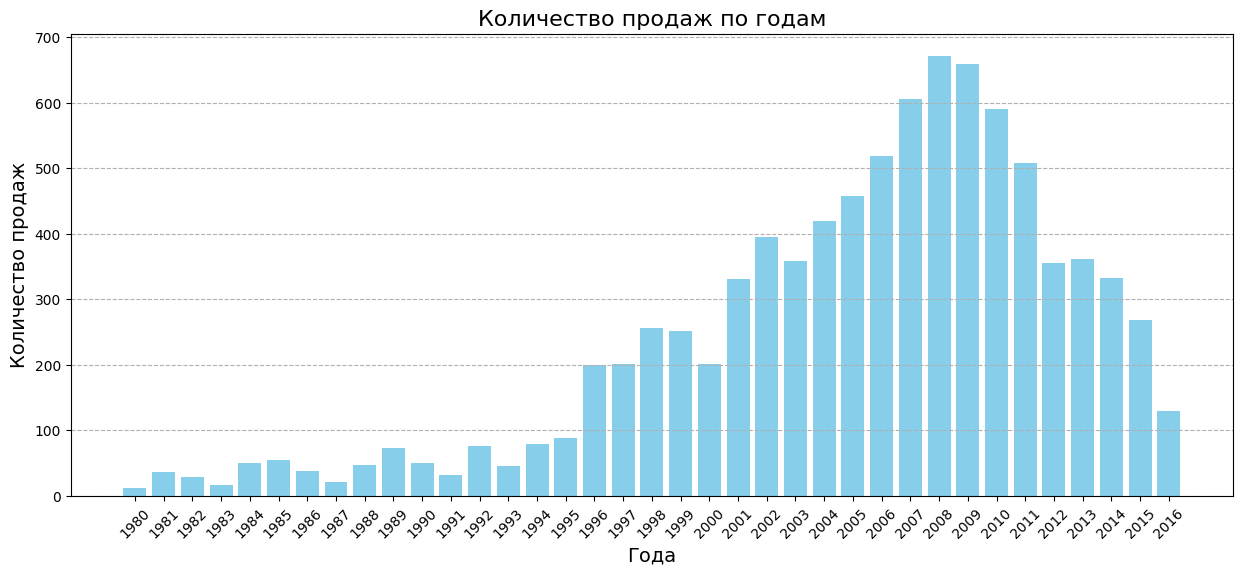

In [119]:
#  График

plt.figure(figsize=(15, 6))
years = total_sales_year.index  # Индекс как годы
values = total_sales_year.values  # Значения продаж

bars = plt.bar(years, values, color='skyblue')
plt.title('Количество продаж по годам', fontsize=16)
plt.xlabel('Года', fontsize=14)
plt.ylabel('Количество продаж', fontsize=14)
plt.grid(axis='y', linestyle='--')
plt.xticks(years, rotation=45)  
plt.show()


В ходе построения проявились года 0. Вернулся и удалил их на более раннем этапе, поэтому здесь они не представлены. Заметный рост (изменение) в продажах наблюдаются после 1995 года, но с 1980 года продажи есть, хотя их значения менялись слабо (циклически). Буду учитывать данные за все представленные года. 

#### 3.2 Данные по платформам

Построю сводную таблицу по платформам

In [120]:
# 
platforms = data['platform']
regions = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
years = data['year_of_release']

platform_sales = data.pivot_table(index='year_of_release', columns='platform', values=regions, aggfunc='sum', fill_value=0)
print(platform_sales.to_string())


                eu_sales                                                                                                                                                                                              jp_sales                                                                                                                                                                                                 na_sales                                                                                                                                                                                                   other_sales                                                                                                                                                                                    
platform            2600  3DO    3DS    DC     DS    GB    GBA     GC   GEN   GG    N64   NES   NG     PC PCFX     PS    PS2    PS3    PS4    PSP   PSV   SAT   SCD  SNES TG16   WS    Wii  Wi

In [121]:
# Получим платформы с наибольшими продажами по годам
top_platforms_per_year = platform_sales.idxmax(axis=1)

# Также можно получить максимальные значения продаж
max_sales_per_year = platform_sales.max(axis=1)

# Объединим результаты в один DataFrame
top_platforms_sales = pd.DataFrame({
    'Top Platform': top_platforms_per_year,
    'Max Sales': max_sales_per_year
})

print(top_platforms_sales)

                     Top Platform  Max Sales
year_of_release                             
1980             (na_sales, 2600)      10.59
1981             (na_sales, 2600)      33.40
1982             (na_sales, 2600)      26.92
1983              (jp_sales, NES)       8.10
1984              (na_sales, NES)      33.02
1985              (na_sales, NES)      33.31
1986              (jp_sales, NES)      19.81
1987              (jp_sales, NES)      11.63
1988              (na_sales, NES)      22.36
1989               (na_sales, GB)      39.81
1990             (na_sales, SNES)      15.28
1991             (jp_sales, SNES)       8.54
1992             (jp_sales, SNES)      19.67
1993             (jp_sales, SNES)      23.21
1994             (jp_sales, SNES)      22.57
1995             (jp_sales, SNES)      22.37
1996               (na_sales, PS)      45.42
1997               (na_sales, PS)      58.06
1998               (na_sales, PS)      83.22
1999               (na_sales, PS)      65.94
2000      

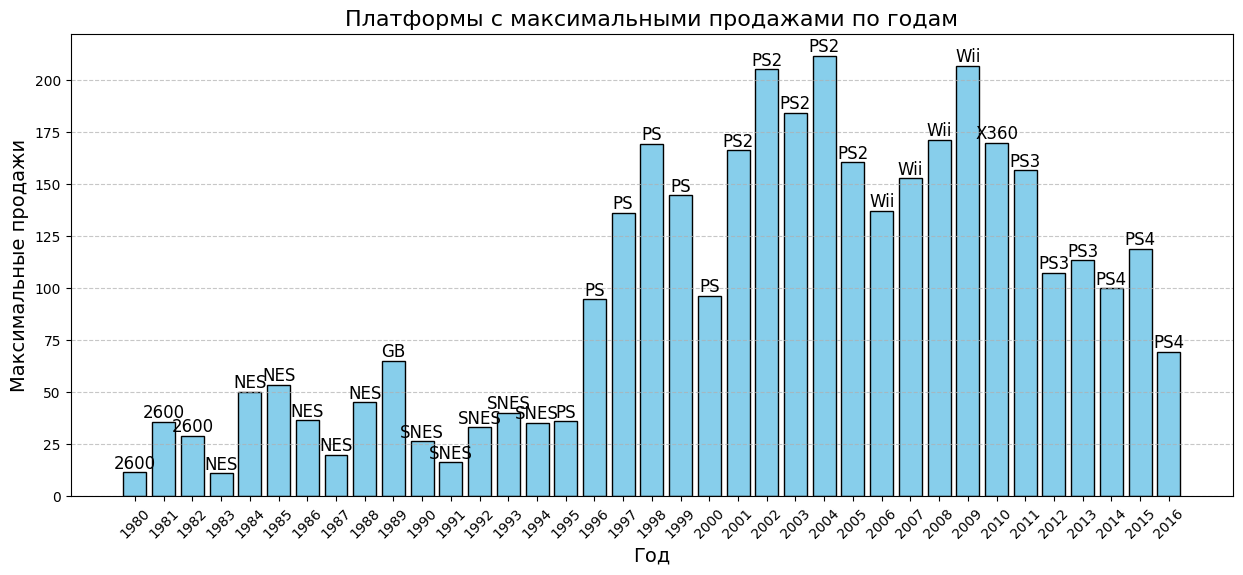

In [122]:
# Группируем по году и платформе, вычисляем суммарные продажи
grouped = data.groupby(['year_of_release', 'platform'])['total_sales'].sum().reset_index()

# Находим платформу с максимальными продажами для каждого года
max_sales_per_year = grouped.loc[grouped.groupby('year_of_release')['total_sales'].idxmax()]

# Построение столбчатой диаграммы
plt.figure(figsize=(15, 6))
plt.bar(max_sales_per_year['year_of_release'], max_sales_per_year['total_sales'], 
        color='skyblue', edgecolor='black')

# Добавление подписей
plt.title('Платформы с максимальными продажами по годам', fontsize=16)
plt.xlabel('Год', fontsize=14)
plt.ylabel('Максимальные продажи', fontsize=14)
plt.xticks(max_sales_per_year['year_of_release'], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

for i, row in max_sales_per_year.iterrows():
    plt.text(row['year_of_release'], row['total_sales'], row['platform'], 
             ha='center', va='bottom', fontsize=12)
    
plt.show()

Выводы:

Платформы появляются и исчезают в среднем каждые 4 - 5 лет.
Новая платформа появляется после начала уменьшения продаж предыдущей.

#### 3.3, 3.4 Актуальный период, выделение данных за актуальный период
В качестве актуального периода беру 2013-2016 год: появилась платформа PS4, начался спад ее продаж - должна появиться новая.

In [123]:
# Отсекаю в новый dataFrame актуальные года
display(data.sort_values('year_of_release'))  # чтобы посмотреть как вышло..
data_actual_years = data[data['year_of_release'] > 2012]
display(data_actual_years.sort_values('year_of_release'))

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
1947,Defender,2600,1980,Misc,0.99,0.05,0.00,0.01,NaN,7.1,NaN,1.05
542,Missile Command,2600,1980,Shooter,2.56,0.17,0.00,0.03,NaN,7.4,NaN,2.76
2613,Boxing,2600,1980,Fighting,0.72,0.04,0.00,0.01,NaN,7.6,NaN,0.77
6202,Bridge,2600,1980,Misc,0.25,0.02,0.00,0.00,NaN,7.1,NaN,0.27
1744,Kaboom!,2600,1980,Misc,1.07,0.07,0.00,0.01,NaN,7.1,NaN,1.15
...,...,...,...,...,...,...,...,...,...,...,...,...
15333,Mighty No. 9,XOne,2016,Platform,0.02,0.00,0.00,0.00,55.0,4.2,E10+,0.02
6070,Monster Hunter Stories,3DS,2016,Action,0.00,0.00,0.28,0.00,NaN,7.4,NaN,0.28
16439,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,NaN,7.4,NaN,0.01
16443,Winning Post 8 2016,PSV,2016,Simulation,0.00,0.00,0.01,0.00,NaN,7.5,NaN,0.01


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14114,Super Robot Taisen OG Saga: Masou Kishin III -...,PSV,2013,Strategy,0.00,0.00,0.03,0.00,NaN,7.8,NaN,0.03
14126,Turbo: Super Stunt Squad,DS,2013,Sports,0.00,0.03,0.00,0.00,NaN,7.4,E,0.03
14146,Toriko: Ultimate Survival,3DS,2013,Action,0.00,0.00,0.03,0.00,NaN,7.4,NaN,0.03
14178,Exstetra,PSV,2013,Role-Playing,0.00,0.00,0.03,0.00,NaN,7.8,NaN,0.03
322,Call of Duty: Ghosts,PS4,2013,Shooter,1.78,1.43,0.05,0.57,78.0,3.7,M,3.83
...,...,...,...,...,...,...,...,...,...,...,...,...
16372,Rugby Challenge 3,XOne,2016,Sports,0.00,0.01,0.00,0.00,NaN,6.6,E,0.01
16359,Sébastien Loeb Rally Evo,XOne,2016,Racing,0.00,0.01,0.00,0.00,63.0,8.2,E,0.01
16352,Norn + Nonette: Act Tune,PSV,2016,Action,0.00,0.00,0.01,0.00,NaN,7.4,NaN,0.01
16346,Codename: Panzers Complete Collection,PC,2016,Strategy,0.00,0.01,0.00,0.00,NaN,7.8,NaN,0.01


In [124]:
# max_sales_per_year_actual = max_sales_per_year[max_sales_per_year['year_of_release'] > 2012]
# display(max_sales_per_year_actual)
grouped_actual = data.groupby(['year_of_release', 'platform'])['total_sales'].sum().reset_index()
grouped_actual = grouped_actual[grouped_actual['year_of_release'] > 2012]
grouped_actual

,year_of_release,platform,total_sales
198,2013,3DS,56.57
199,2013,DS,1.54
200,2013,PC,12.38
201,2013,PS3,113.25
202,2013,PS4,25.99
203,2013,PSP,3.14
204,2013,PSV,10.59
205,2013,Wii,8.59
206,2013,WiiU,21.65
207,2013,X360,88.58


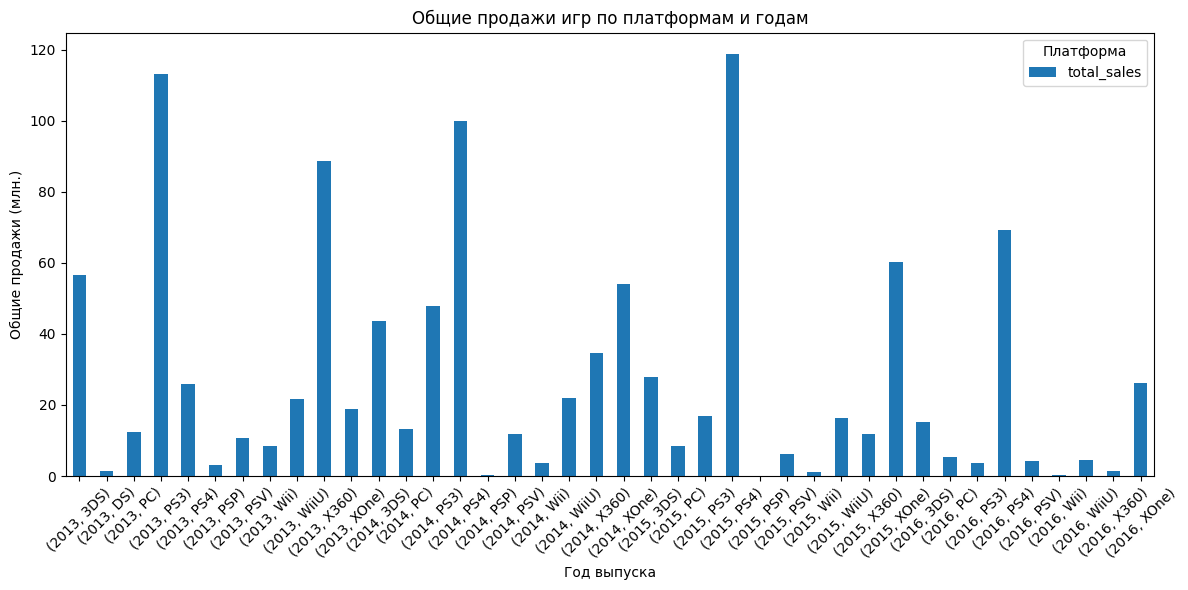

In [125]:
# Построим столбчатую диаграмму
plt.figure(figsize=(12, 6))
grouped_actual.groupby(['year_of_release', 'platform'])['total_sales'].sum().plot(kind='bar', stacked=True)
plt.title('Общие продажи игр по платформам и годам')
plt.xlabel('Год выпуска')
plt.ylabel('Общие продажи (млн.)')
plt.legend(title='Платформа')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Выводы по графику (2013 - 2016):

Значительно выделяются платформы:

- РС (непрерывно падают продажи)
- WiiU (непрерывно падают )
- Х360 (удерживают значительную долю)
- PS3 (значительный рост и лидерство до 2016 года) - останется в лидерах
- XOne (новая платформа)

лидеры, которые скорее всего останутся таковыми - PS3, X360.

#### 3.5  Ящик с усами


<Figure size 1200x600 with 0 Axes>

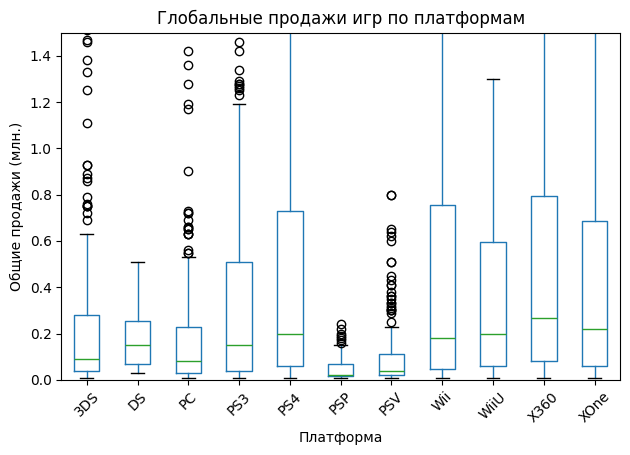

In [126]:
# Ящик с усами
# Строим график "ящик с усами"
plt.figure(figsize=(12, 6))
data_actual_years.boxplot(column='total_sales', by='platform', grid=False)
plt.ylim(0, 1.5)
plt.title('Глобальные продажи игр по платформам')
plt.suptitle('')  # Убираем стандартный заголовок
plt.xlabel('Платформа')
plt.ylabel('Общие продажи (млн.)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### 3.6 Влияние отзывов на продажи
Для примера возьмём PS3

In [127]:
# Берём данные за актуальный период

data_ps3 = data_actual_years[data_actual_years['platform'] == 'PS3']
# data_ps3.describe()

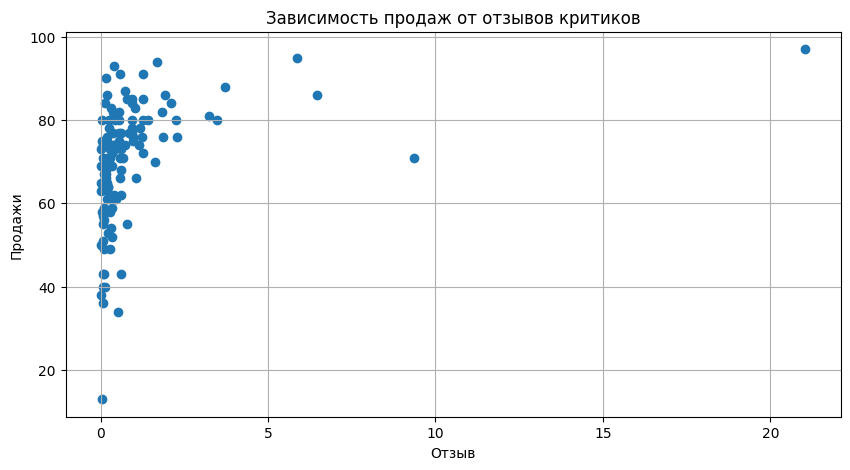

0.3342853393371919


In [128]:
# Строим график зависимости sales от отзывов критиков
plt.figure(figsize=(10, 5))
plt.scatter(x=data_ps3['total_sales'], y=data_ps3['critic_score'], marker='o')
plt.title('Зависимость продаж от отзывов критиков')
plt.xlabel('Отзыв')
plt.ylabel('Продажи')
plt.grid()
plt.show()

# Считаем коэффициент корреляции
print(data_ps3['critic_score'].corr(data_ps3['total_sales']))


Корреляция слабая. Отзывы критиков слабо влияют на продажи, но всё-таки более высокие отзывы увеличивают продажи.

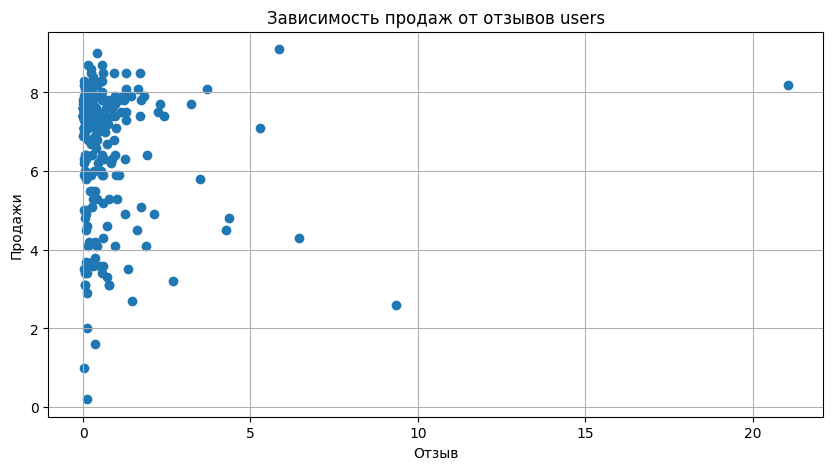

-0.08598425479117172


In [129]:
# Строим график зависимости sales от user_score
plt.figure(figsize=(10, 5))
plt.scatter(x=data_ps3['total_sales'], y=data_ps3['user_score'], marker='o')
plt.title('Зависимость продаж от отзывов users')
plt.xlabel('Отзыв')
plt.ylabel('Продажи')
plt.grid()
plt.show()

# Считаем коэффициент корреляции
print(data_ps3['user_score'].corr(data_ps3['total_sales']))

Крреляция слабо отрицательная. Чем выше отзывы тем меньше продажи. Но влияние слабое.
Проверим на платформах  X360, PC


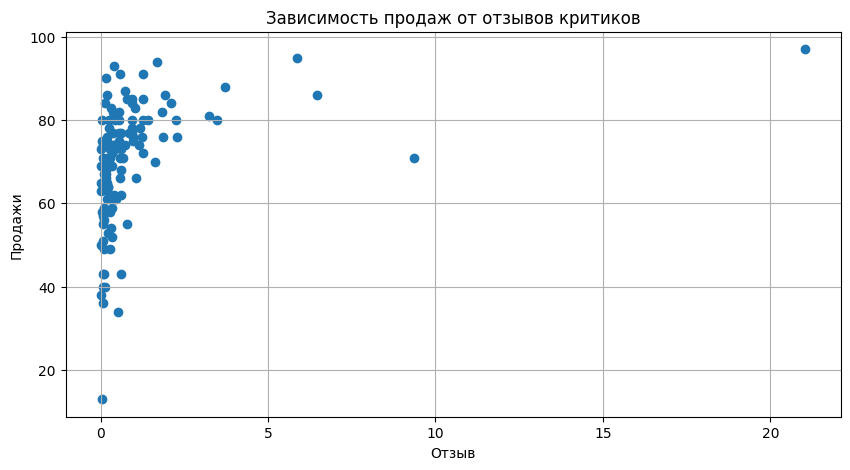

0.3503445460228664


In [130]:
# X360

data_x360 = data_actual_years[data_actual_years['platform'] == 'X360']
# Строим график зависимости sales от year
plt.figure(figsize=(10, 5))
plt.scatter(x=data_ps3['total_sales'], y=data_ps3['critic_score'], marker='o')
plt.title('Зависимость продаж от отзывов критиков')
plt.xlabel('Отзыв')
plt.ylabel('Продажи')
plt.grid()
plt.show()

# Считаем коэффициент корреляции
print(data_x360['critic_score'].corr(data_x360['total_sales']))

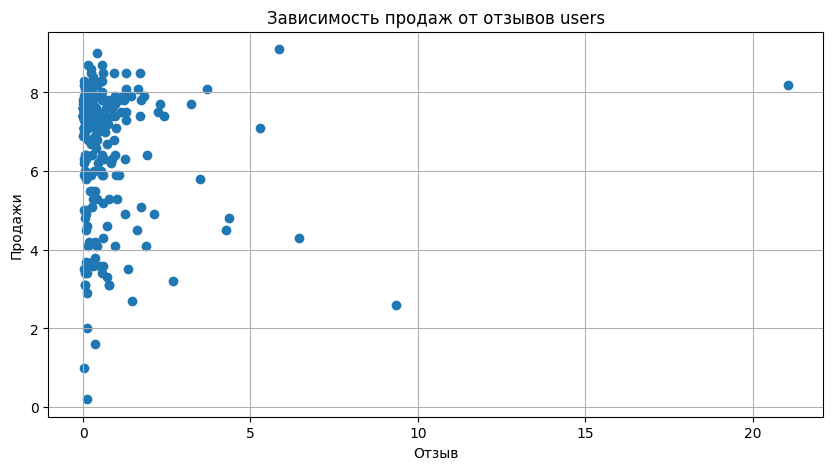

-0.04974201943138053


In [131]:
# X360

data_x360 = data_actual_years[data_actual_years['platform'] == 'X360']
# Строим график зависимости sales от year
plt.figure(figsize=(10, 5))
plt.scatter(x=data_ps3['total_sales'], y=data_ps3['user_score'], marker='o')
plt.title('Зависимость продаж от отзывов users')
plt.xlabel('Отзыв')
plt.ylabel('Продажи')
plt.grid()
plt.show()
print(data_x360['user_score'].corr(data_x360['total_sales']))

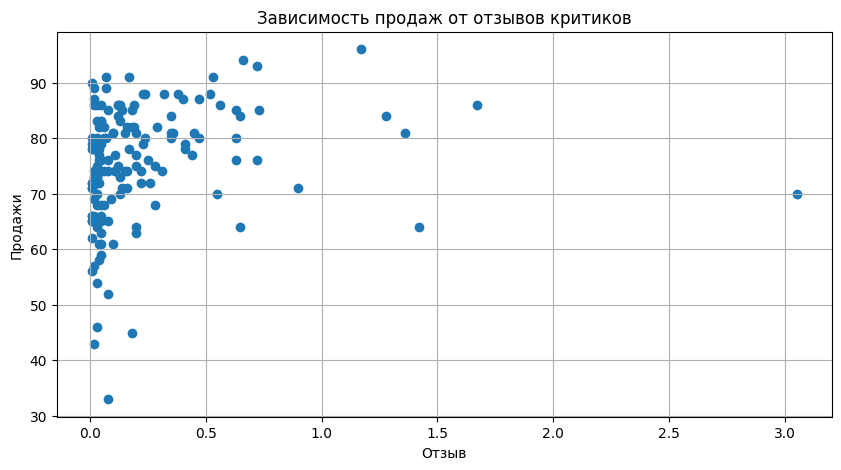

0.1960302829436937


In [132]:
# PC

data_pc = data_actual_years[data_actual_years['platform'] == 'PC']
# Строим график зависимости sales от year
plt.figure(figsize=(10, 5))
plt.scatter(x=data_pc['total_sales'], y=data_pc['critic_score'], marker='o')
plt.title('Зависимость продаж от отзывов критиков')
plt.xlabel('Отзыв')
plt.ylabel('Продажи')
plt.grid()
plt.show()

# Считаем коэффициент корреляции
print(data_pc['critic_score'].corr(data_pc['total_sales']))

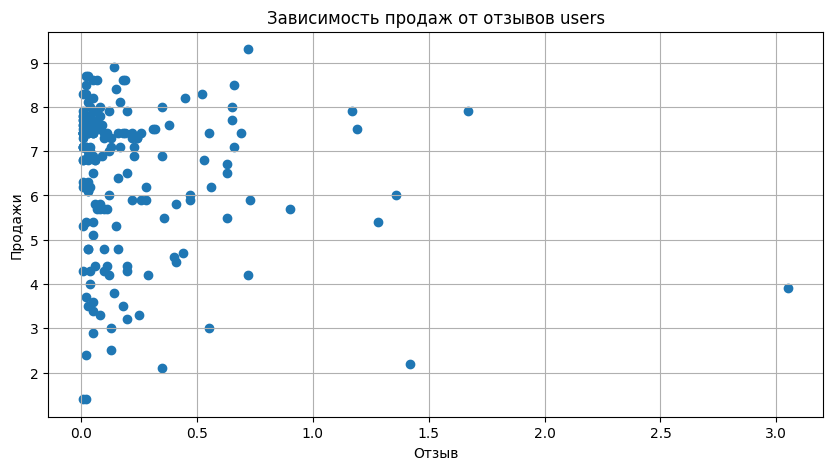

-0.11686166164546588


In [133]:
# PC

data_pc = data_actual_years[data_actual_years['platform'] == 'PC']
# Строим график зависимости sales от year
plt.figure(figsize=(10, 5))
plt.scatter(x=data_pc['total_sales'], y=data_pc['user_score'], marker='o')
plt.title('Зависимость продаж от отзывов users')
plt.xlabel('Отзыв')
plt.ylabel('Продажи')
plt.grid()
plt.show()
print(data_pc['user_score'].corr(data_pc['total_sales']))

На двух других популярных платформах картина та же: отзывы критиков - слабая положительная корреляция, с отзывами пользователей - очеyь слабая отрицательная

#### 3.7 Исследование жанров


Рассмотрим распределение по жанрам

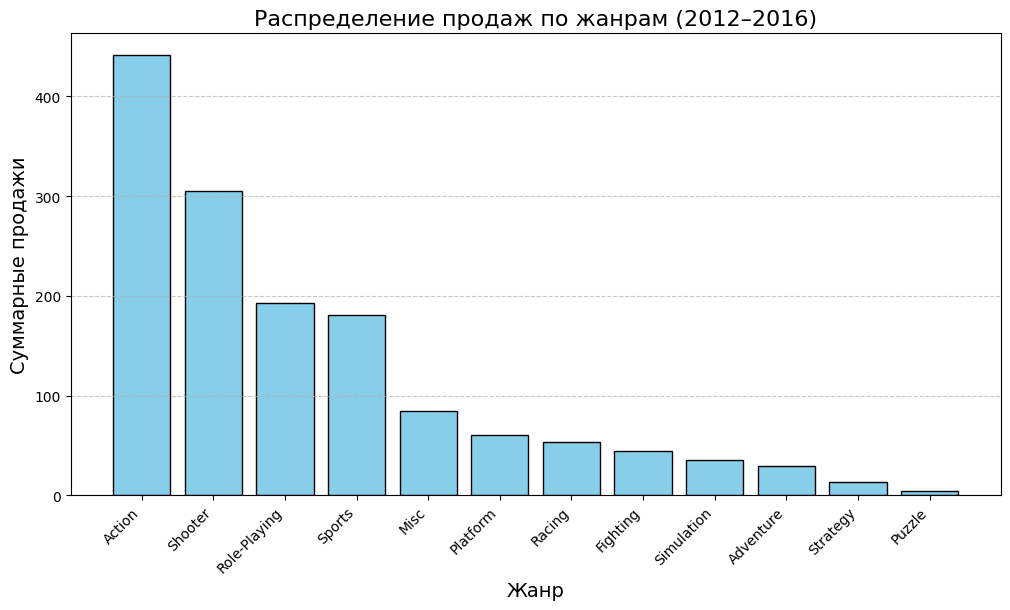

In [134]:
# Фильтрация данных по годам 2012–2016 и создание явной копии
filtered_data = data[(data['year_of_release'] >= 2012) & (data['year_of_release'] <= 2016)].copy()

# Вычисление общих продаж для каждой игры
filtered_data.loc[:, 'total_sales'] = filtered_data[['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

# Группировка по жанрам и вычисление суммарных продаж
genre_sales = filtered_data.groupby('genre')['total_sales'].sum().reset_index()

# Сортировка по убыванию продаж
genre_sales = genre_sales.sort_values(by='total_sales', ascending=False)

# Построение столбчатой диаграммы
plt.figure(figsize=(12, 6))
plt.bar(genre_sales['genre'], genre_sales['total_sales'], color='skyblue', edgecolor='black')

# Добавление подписей
plt.title('Распределение продаж по жанрам (2012–2016)', fontsize=16)
plt.xlabel('Жанр', fontsize=14)
plt.ylabel('Суммарные продажи', fontsize=14)
plt.xticks(rotation=45, ha='right')  # Поворот подписей по оси X для удобства
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показать график
plt.show()



Выводы:

Наиболее популярны игры жанра Action, Shooter, седом за ними близко друг к другу Role-Playing, Sports.


### 4. Портрет пользователя

#### 4.1 Топ - 5 платформ

   platform  na_sales  eu_sales  jp_sales  other_sales
0       3DS     55.31     42.64     87.79         8.87
1        DS      4.59      3.53      3.72         0.71
2        PC     19.12     37.76      0.00         5.77
3       PS3    103.38    106.86     35.29        43.26
4       PS4    108.74    141.09     15.96        48.35
5       PSP      0.13      0.42     10.47         0.17
6       PSV     10.98     11.36     21.04         5.80
7       Wii     17.45     11.92      3.39         2.61
8      WiiU     38.10     25.13     13.01         5.95
9      X360    140.05     74.52      1.57        20.40
10     XOne     93.12     51.59      0.34        14.27


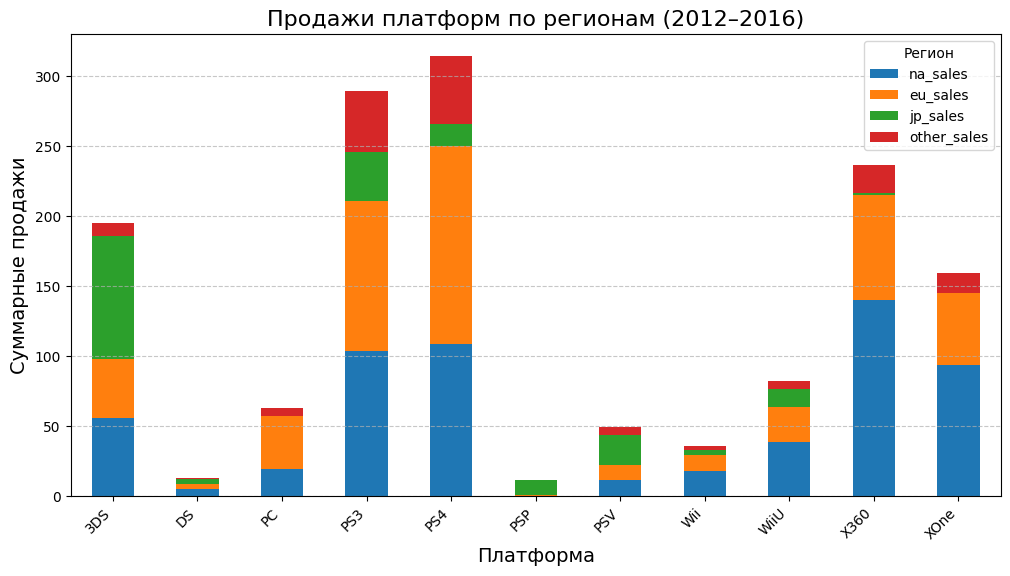

In [135]:
# Фильтрация данных по годам 2012–2016
# filtered_data = data[(data['year_of_release'] >= 2012) & (data['year_of_release'] <= 2016)].copy()

# Группировка по платформам и вычисление суммарных продаж для каждого региона
platform_sales = filtered_data.groupby('platform').agg({
    'na_sales': 'sum',
    'eu_sales': 'sum',
    'jp_sales': 'sum',
    'other_sales': 'sum'
}).reset_index()

# Вывод результата
print(platform_sales)

# Визуализация
platform_sales.set_index('platform').plot(kind='bar', stacked=True, figsize=(12, 6))

# Настройка графика
plt.title('Продажи платформ по регионам (2012–2016)', fontsize=16)
plt.xlabel('Платформа', fontsize=14)
plt.ylabel('Суммарные продажи', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Регион')
plt.show()

Вывод:

Наиболее популярные платформы в актуальном периоде - PS3, PS4, X360. XOne только вышла но ужеь отстаёт совсем немного. PS3, PS4 - производство Японии - продажи в Европе немного больше североамериканских, тогда как Х360 - американская разработка - явно большие продажи северо-американсуком регионе.

#### 4.2 Самые популярные жанры

           genre  na_sales  eu_sales  jp_sales  other_sales
0         Action    177.84    159.34     52.80        51.14
1      Adventure      8.92      9.46      8.24         2.81
2       Fighting     19.79     10.79      9.44         4.47
3           Misc     38.19     26.32     12.86         7.67
4       Platform     25.38     21.41      8.63         5.58
5         Puzzle      1.13      1.40      2.14         0.22
6         Racing     17.22     27.29      2.50         6.49
7   Role-Playing     64.00     48.53     65.44        14.83
8        Shooter    144.77    113.47      9.23        37.26
9     Simulation      7.97     14.55     10.41         2.19
10        Sports     81.53     69.09      8.01        22.44
11      Strategy      4.23      5.17      2.88         1.06


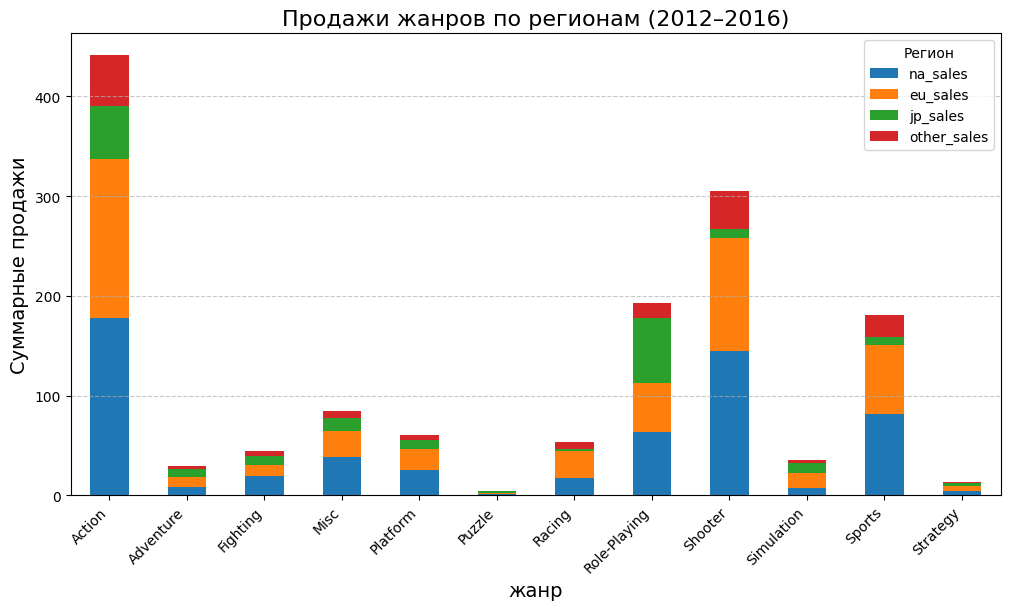

In [136]:
# Группировка по платформам и вычисление суммарных продаж для каждого региона
genre_sales = filtered_data.groupby('genre').agg({
    'na_sales': 'sum',
    'eu_sales': 'sum',
    'jp_sales': 'sum',
    'other_sales': 'sum'
}).reset_index()

# Вывод результата
print(genre_sales)

# Визуализация
genre_sales.set_index('genre').plot(kind='bar', stacked=True, figsize=(12, 6))

# Настройка графика
plt.title('Продажи жанров по регионам (2012–2016)', fontsize=16)
plt.xlabel('жанр', fontsize=14)
plt.ylabel('Суммарные продажи', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Регион')
plt.show()

Выводы:
В явных лидерах продаж игры жанров  Actions, Sports, Shooter, Role-Playing - все связанные с виртуальной активностью. Возможно стоит провести исследование специальными медицинскими организациями и провести пропаганду здорового и активного образа жизни..

#### 4.2 Влияние рейтинга ESRB

  rating  na_sales  eu_sales  jp_sales  other_sales
0      E    114.37    113.03     28.33        31.44
1   E10+     75.70     55.37      8.19        16.23
2      M    231.57    193.96     21.20        63.38
3      T     66.02     52.96     26.02        17.94


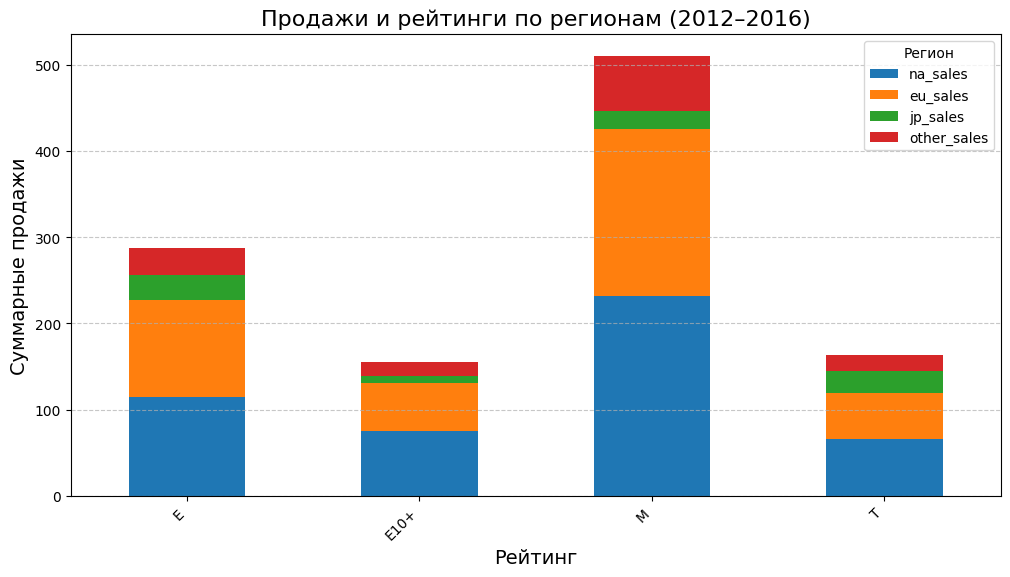

In [137]:
# Группировка по рейтингам и вычисление суммарных продаж для каждого региона
rating_sales = filtered_data.groupby('rating').agg({
    'na_sales': 'sum',
    'eu_sales': 'sum',
    'jp_sales': 'sum',
    'other_sales': 'sum'
}).reset_index()

# Вывод результата
print(rating_sales)

# Визуализация
rating_sales.set_index('rating').plot(kind='bar', stacked=True, figsize=(12, 6))

# Настройка графика
plt.title('Продажи и рейтинги по регионам (2012–2016)', fontsize=16)
plt.xlabel('Рейтинг', fontsize=14)
plt.ylabel('Суммарные продажи', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Регион')
plt.show()

Выводы:
Судя по распределению продаж по возрастным рейтингам - во всех регионах распределение примерно одинаковое. По объёмам продаж - с большим отрывом лидирует рейтинг M.

### 5. Проверка гипотез

#### 5.1  Средние пользовательские рейтинги платформ XBox One и РС одинаковые

Нулевая гипотеза H<sub>0</sub>: Средний пользовательский рейтинг платформы XBox One равен среднему пользовательскому рейтингу платформ РС.

Альтернативная гипотеза H<sub>1</sub>: Средний пользовательский рейтинг платформы XBox One больше  среднего пользовательского рейтинга платформы РС.

In [138]:
# Собираем пользовательские рейтинги

# XBox One
xBox_user_score = filtered_data[filtered_data['platform'] == 'XOne']
display(xBox_user_score.head())

# PC
pc_user_score = filtered_data[filtered_data['platform'] == 'PC']
display(pc_user_score.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,7.4,NaN,7.39
165,Grand Theft Auto V,XOne,2014,Action,2.81,2.19,0.00,0.47,97.0,7.9,M,5.47
179,Call of Duty: Advanced Warfare,XOne,2014,Shooter,3.22,1.55,0.01,0.48,81.0,5.4,M,5.26
241,Halo 5: Guardians,XOne,2015,Shooter,2.78,1.27,0.03,0.41,84.0,6.4,T,4.49
269,Fallout 4,XOne,2015,Role-Playing,2.51,1.32,0.01,0.38,88.0,6.2,M,4.22


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
191,Diablo III,PC,2012,Role-Playing,2.44,2.16,0.0,0.54,88.0,4.0,M,5.14
455,The Sims 4,PC,2014,Simulation,1.00,1.82,0.0,0.23,70.0,3.9,T,3.05
679,Guild Wars 2,PC,2012,Action,0.96,1.07,0.0,0.27,90.0,7.9,T,2.30
948,World of Warcraft: Mists of Pandaria,PC,2012,Role-Playing,0.84,0.76,0.0,0.22,82.0,4.8,T,1.82
1084,StarCraft II: Heart of the Swarm,PC,2013,Strategy,0.83,0.66,0.0,0.18,86.0,7.9,T,1.67


In [139]:
# Проверка гипотезы

alpha = 0.05 # уровень статистической значимости

xbox_users = xBox_user_score['user_score']
pc_users = pc_user_score['user_score']

results = st.ttest_ind(xbox_users, pc_users, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевая гипотеза подтвердилась')

p-значение: 0.1262129328597794
Нулевая гипотеза подтвердилась


Вывод:
Средний пользовательский рейтинг платформы XOne равен среднему пользовательскому рейтингу РС.

 #### 5.2 Средние пользовательские рейтинги жанров Action и Sports равны

Нулевая гипотеза H<sub>0</sub>: средний рейтинг пользователей игр жанра Action равен среднему рейтингу игр жанра Sports.

 Альтернативная гипотеза H<sub>1</sub>: средний рейтинг пользоавтелей игр жанра Action отличен от  среднего рейтинга игр жанра Sports.

In [140]:
# Собираем данные для анализа

# Собираем пользовательские рейтинги

# genre Action
genre_action_user_score = filtered_data[filtered_data['genre'] == 'Action']
display(xBox_user_score.head())

# PC
genre_sports_user_score = filtered_data[filtered_data['genre'] == 'Sports']
display(pc_user_score.head())

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
99,Call of Duty: Black Ops 3,XOne,2015,Shooter,4.59,2.11,0.01,0.68,NaN,7.4,NaN,7.39
165,Grand Theft Auto V,XOne,2014,Action,2.81,2.19,0.00,0.47,97.0,7.9,M,5.47
179,Call of Duty: Advanced Warfare,XOne,2014,Shooter,3.22,1.55,0.01,0.48,81.0,5.4,M,5.26
241,Halo 5: Guardians,XOne,2015,Shooter,2.78,1.27,0.03,0.41,84.0,6.4,T,4.49
269,Fallout 4,XOne,2015,Role-Playing,2.51,1.32,0.01,0.38,88.0,6.2,M,4.22


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
191,Diablo III,PC,2012,Role-Playing,2.44,2.16,0.0,0.54,88.0,4.0,M,5.14
455,The Sims 4,PC,2014,Simulation,1.00,1.82,0.0,0.23,70.0,3.9,T,3.05
679,Guild Wars 2,PC,2012,Action,0.96,1.07,0.0,0.27,90.0,7.9,T,2.30
948,World of Warcraft: Mists of Pandaria,PC,2012,Role-Playing,0.84,0.76,0.0,0.22,82.0,4.8,T,1.82
1084,StarCraft II: Heart of the Swarm,PC,2013,Strategy,0.83,0.66,0.0,0.18,86.0,7.9,T,1.67


In [141]:
# Проверка гипотезы

alpha = 0.05 # уровень статистической значимости

action_users = genre_action_user_score['user_score']
sports_users = genre_sports_user_score['user_score']

results = st.ttest_ind(action_users, sports_users, alternative='greater')

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нулевая гипотеза подтвердилась')

p-значение: 3.3538343050109556e-40
Отвергаем нулевую гипотезу


Вывод: Нулевая гипотеза не подтвердилась, по оценкам пользователей рейтинг игр в жанре Actions выше чем в жанре Sports.

### Выводы

<em>В ходе работы с данными были проведены: 
- предварительная обработка, заполнение пропусков, фильтрация аномальных значений;
- анализ распределений продаж по различным критериям;
- анализ популярности платформ;
- анализ влияния отзывов критиков и пользователей.</em>

<b>Заключение</b>
1. В продажах по всем тсследуемым платформам с 2010 года наблюдается общий спад.
2. В актуальном периоде наиболее успешны платформы серии PS, XBox One, X360, удерживается на своём уровне продаж РС.
   Судя по цикличности появления и ухода платформ (4-5 лет) PS3 через 1-2 года полностью уйдет с рынка, PS4 находится в начале падения; в ближайшее время наиболее популярны будут новые XBox One, X360;
3. Влияние отзывов: отзывы критиков слабо коррелируют с показателями продаж, высокие отзывы слабо увеличивают, а отзывы пользователей имеют отрицательную корреляцию - высокие оценки пользователей даже уменьшают продажи;
4. Жанры. Наиболее популярны в настоящее время жанры Action, Shooter, Role-playing, Sports.
5. Влияние региона. На объём продаж влияет регион создания платформы -  в "родном" регионе продажи выше.
6. Возрастной рейтинг. Наиболее продаваемы игры возрастной категории "М". Рапределение продаж по возрастному рейтингу по регионам практически не меняется.
7. Проверка гипотез. Проверка показала, что средние рейтинги от пользователей для платформ ХВох Опе и РС близки, тогда как предположение о равенстве рейтингов жанров Action и Sports не подтвердились.

Окончательный вывод: <strong>максимальные продажи в следующем году стоит ожидать для игр в жанре Action для платформы XBox One для возрастной категории М.</strong>